# Proyek Klasifikasi Gambar: [Rice Image Dataset]
- **Nama:** [Darojatul Alya Anwar]
- **Email:** [mc227d5x2095@student.devacademy.id]
- **ID Dicoding:** [MC227D5X2095]

## Import Semua Packages/Library yang Digunakan

In [10]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [11]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [12]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [15]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"darojatulalyaanwar","key":"9eb6b8a93a85f472083aaebfd921e3b4"}'}

In [16]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [17]:
# Mengunduh dataset Rice Image dari Kaggle
!kaggle datasets download -d ayanwap7/rice-image-dataset-train-test-split

# Mengekstrak file ZIP
!unzip rice-image-dataset-train-test-split.zip -d rice_image_dataset

Streaming output truncated to the last 5000 lines.
  inflating: rice_image_dataset/Rice_Image_Dataset/train/Karacadag/Karacadag (2799).jpg  
  inflating: rice_image_dataset/Rice_Image_Dataset/train/Karacadag/Karacadag (28).jpg  
  inflating: rice_image_dataset/Rice_Image_Dataset/train/Karacadag/Karacadag (280).jpg  
  inflating: rice_image_dataset/Rice_Image_Dataset/train/Karacadag/Karacadag (2800).jpg  
  inflating: rice_image_dataset/Rice_Image_Dataset/train/Karacadag/Karacadag (2801).jpg  
  inflating: rice_image_dataset/Rice_Image_Dataset/train/Karacadag/Karacadag (2802).jpg  
  inflating: rice_image_dataset/Rice_Image_Dataset/train/Karacadag/Karacadag (2803).jpg  
  inflating: rice_image_dataset/Rice_Image_Dataset/train/Karacadag/Karacadag (2804).jpg  
  inflating: rice_image_dataset/Rice_Image_Dataset/train/Karacadag/Karacadag (2805).jpg  
  inflating: rice_image_dataset/Rice_Image_Dataset/train/Karacadag/Karacadag (2806).jpg  
  inflating: rice_image_dataset/Rice_Image_Dataset/t

In [18]:
!ls rice_image_dataset

Rice_Image_Dataset


### Data Preprocessing

In [19]:
import os
import shutil

In [20]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Direktori awal untuk train dan test
train_dir = "rice_image_dataset/Rice_Image_Dataset/train"
test_dir = "rice_image_dataset/Rice_Image_Dataset/test"

# Direktori baru untuk dataset gabungan
combined_dir = "rice_dataset/dataset"

In [ ]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [22]:
import os
print(os.listdir()) # Menampilkan isi direktori kerja

['.config', '.ipynb_checkpoints', 'melanoma_dataset', 'rice_image_dataset', 'kaggle.json', 'kaggle (1).json', 'rice-image-dataset-train-test-split.zip', 'sample_data']


In [23]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

Dataset Checking

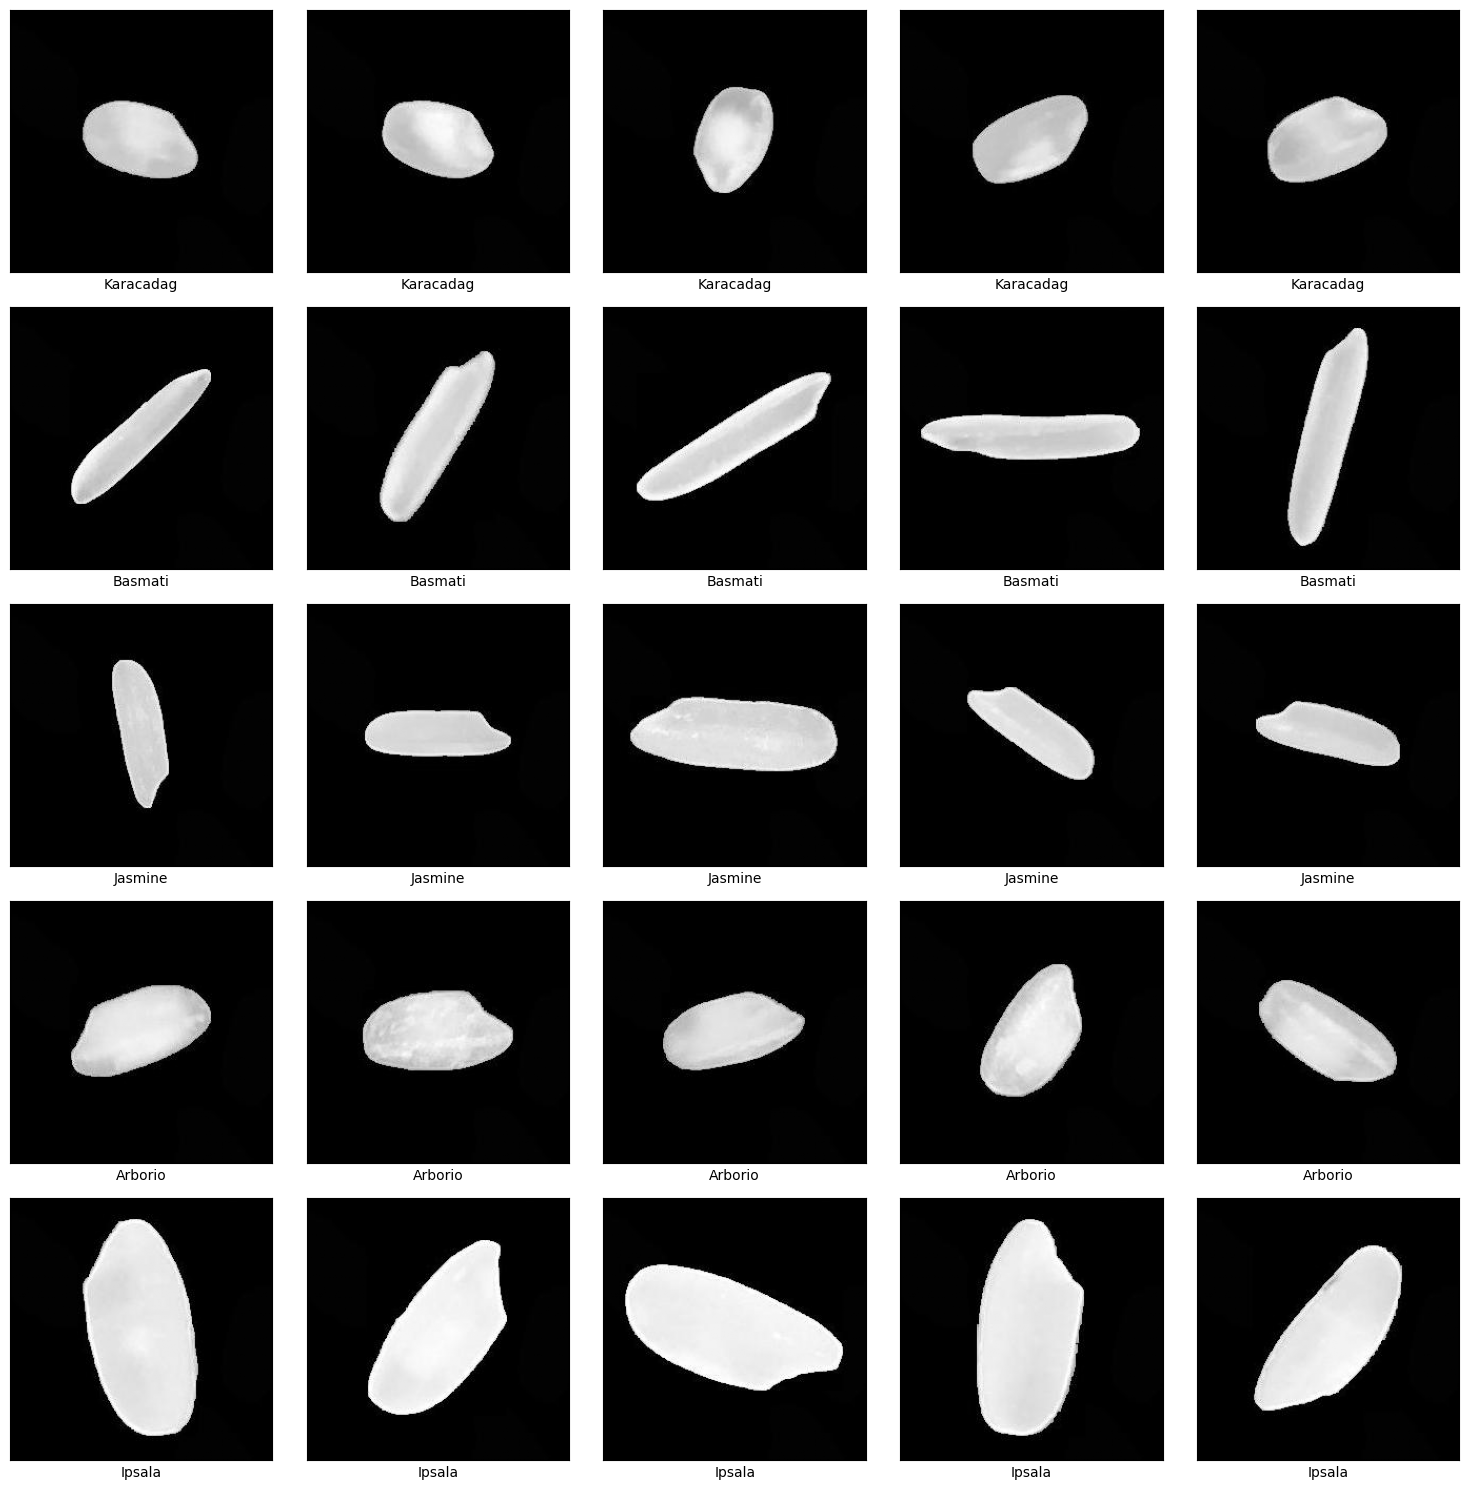

In [32]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = "rice_dataset/"
path_sub = os.path.join(path, "dataset")

# Mengisi kamus lung_image dengan gambar dari setiap kelas
for class_name in os.listdir(path_sub):
    class_path = os.path.join(path_sub, class_name)
    if os.path.isdir(class_path):  # Pastikan ini adalah folder kelas
        lung_image[class_name] = os.listdir(class_path)

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
for i, class_name in enumerate(lung_image.keys()):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()


Plot Distribusi

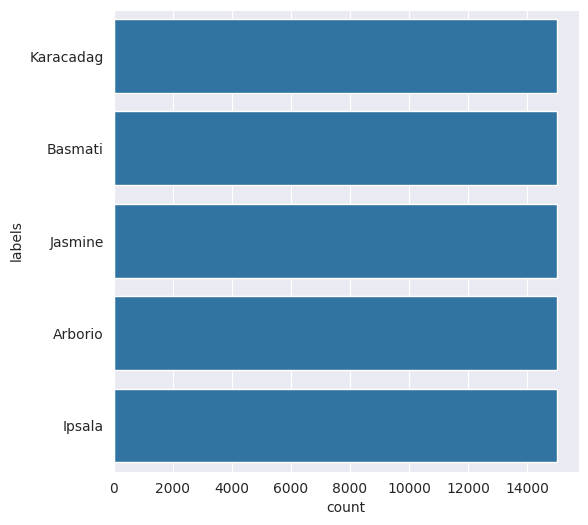

In [33]:
# Definisikan path sumber
lung_path = "rice_dataset/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)


#### Split Dataset

In [34]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'rice_dataset/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Arborio,15000
Basmati,15000
Ipsala,15000
Jasmine,15000
Karacadag,15000


In [35]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [36]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [37]:
# Gabungkan DataFrame df_tr, df_te, dan df_va
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "rice_dataset/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training, testing, dan validation
dataset_path = "Dataset-Final/"


set    labels   
test   Arborio       2983
       Basmati       2963
       Ipsala        2988
       Jasmine       3040
       Karacadag     3026
train  Arborio      12017
       Basmati      12037
       Ipsala       12012
       Jasmine      11960
       Karacadag    11974
dtype: int64 


                                                    path     labels    set
63582  rice_dataset/dataset/Karacadag/Karacadag (1878...  Karacadag   test
1579     rice_dataset/dataset/Basmati/basmati (6530).jpg    Basmati  train
14375    rice_dataset/dataset/Jasmine/Jasmine (8234).jpg    Jasmine  train
2084    rice_dataset/dataset/Basmati/basmati (11306).jpg    Basmati  train
6358     rice_dataset/dataset/Basmati/basmati (4323).jpg    Basmati  train


In [38]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

IMAGE DATA GENERATOR

In [39]:
import os

# Definisikan direktori training dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

# Direktori untuk setiap kelas
train_arborio = os.path.join(TRAIN_DIR, 'Arborio')
train_basmati = os.path.join(TRAIN_DIR, 'Basmati')
train_ipsala = os.path.join(TRAIN_DIR, 'Ipsala')
train_jasmine = os.path.join(TRAIN_DIR, 'Jasmine')
train_karacadag = os.path.join(TRAIN_DIR, 'Karacadag')

test_arborio = os.path.join(TEST_DIR, 'Arborio')
test_basmati = os.path.join(TEST_DIR, 'Basmati')
test_ipsala = os.path.join(TEST_DIR, 'Ipsala')
test_jasmine = os.path.join(TEST_DIR, 'Jasmine')
test_karacadag = os.path.join(TEST_DIR, 'Karacadag')

# Menampilkan jumlah gambar
print("Total gambar Arborio di training set: ", len(os.listdir(train_arborio)))
print("Total gambar Basmati di training set: ", len(os.listdir(train_basmati)))
print("Total gambar Ipsala di training set: ", len(os.listdir(train_ipsala)))
print("Total gambar Jasmine di training set: ", len(os.listdir(train_jasmine)))
print("Total gambar Karacadag di training set: ", len(os.listdir(train_karacadag)))

print("Total gambar Arborio di test set: ", len(os.listdir(test_arborio)))
print("Total gambar Basmati di test set: ", len(os.listdir(test_basmati)))
print("Total gambar Ipsala di test set: ", len(os.listdir(test_ipsala)))
print("Total gambar Jasmine di test set: ", len(os.listdir(test_jasmine)))
print("Total gambar Karacadag di test set: ", len(os.listdir(test_karacadag)))


Total gambar Arborio di training set:  12017
Total gambar Basmati di training set:  12037
Total gambar Ipsala di training set:  12012
Total gambar Jasmine di training set:  11960
Total gambar Karacadag di training set:  11974
Total gambar Arborio di test set:  2983
Total gambar Basmati di test set:  2963
Total gambar Ipsala di test set:  2988
Total gambar Jasmine di test set:  3040
Total gambar Karacadag di test set:  3026


In [40]:
# Buat objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                color_mode="grayscale",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 48002 images belonging to 5 classes.
Found 11998 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


## Modelling

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

model_1 = Sequential()

# Convolutional layer, Batch Normalization, and Pooling
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())

# Fully connected layer
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))

model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.3))

# Final Dense layer for output prediction (5 classes, softmax for multi-class classification)
model_1.add(Dense(5, activation='softmax')) # 5 kelas

# Compile the model
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='categorical_crossentropy',  # Menggunakan categorical crossentropy
                metrics=['accuracy'])

# Print the summary of the model
print(model_1.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,141 (5.35 MB)

 Trainable params: 1,402,949 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [43]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

## Evaluasi dan Visualisasi

In [44]:
import os

# Definisikan direktori untuk data training
TRAIN_DIR = "Dataset-Final/train/"

# Nama kelas
classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

# Hitung jumlah gambar untuk setiap kelas
count_arborio = len(os.listdir(os.path.join(TRAIN_DIR, 'Arborio')))
count_basmati = len(os.listdir(os.path.join(TRAIN_DIR, 'Basmati')))
count_ipsala = len(os.listdir(os.path.join(TRAIN_DIR, 'Ipsala')))
count_jasmine = len(os.listdir(os.path.join(TRAIN_DIR, 'Jasmine')))
count_karacadag = len(os.listdir(os.path.join(TRAIN_DIR, 'Karacadag')))

# Hitung total jumlah gambar dalam dataset
total_images = count_arborio + count_basmati + count_ipsala + count_jasmine + count_karacadag

# Hitung bobot class (class_weight) untuk menangani imbalance
weight_arborio = (1 / count_arborio) * (total_images / 5.0)
weight_basmati = (1 / count_basmati) * (total_images / 5.0)
weight_ipsala = (1 / count_ipsala) * (total_images / 5.0)
weight_jasmine = (1 / count_jasmine) * (total_images / 5.0)
weight_karacadag = (1 / count_karacadag) * (total_images / 5.0)

# Menyusun dictionary class_weights
class_weights = {
    'Arborio': weight_arborio,
    'Basmati': weight_basmati,
    'Ipsala': weight_ipsala,
    'Jasmine': weight_jasmine,
    'Karacadag': weight_karacadag
}

# Menampilkan hasil bobot kelas
print("Class Weights:", class_weights)


Class Weights: {'Arborio': 0.9985853374386285, 'Basmati': 0.9969261443881365, 'Ipsala': 0.999000999000999, 'Jasmine': 1.0033444816053512, 'Karacadag': 1.002171371304493}


In [45]:
import os

# Direktori untuk data training
TRAIN_DIR = "Dataset-Final/train/"

# Nama kelas
classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

# Hitung jumlah gambar untuk setiap kelas
counts = {class_name: len(os.listdir(os.path.join(TRAIN_DIR, class_name))) for class_name in classes}

# Hitung total jumlah gambar dalam dataset
total_images = sum(counts.values())

# Hitung bobot class (class_weight) untuk menangani imbalance
class_weights = {}
for idx, class_name in enumerate(classes):
    class_weights[idx] = (1 / counts[class_name]) * (total_images / len(classes))

# Menampilkan bobot kelas
print("Class Weights:", class_weights)

# Menggunakan %time untuk mengukur waktu eksekusi pelatihan
%time

# Melatih model dengan class_weight
history_1 = model_1.fit(
    train_generator,
    epochs=30,  # Anda bisa mengganti ini ke 50 jika ingin lebih banyak epoch
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights  # Menambahkan class_weight di sini
)


Class Weights: {0: 0.9985853374386285, 1: 0.9969261443881365, 2: 0.999000999000999, 3: 1.0033444816053512, 4: 1.002171371304493}
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.48 µs
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1501/1501 ━━━━━━━━━━━━━━━━━━━━ 73s 43ms/step - accuracy: 0.7162 - loss: 0.9246 - val_accuracy: 0.9551 - val_loss: 0.1562
Epoch 2/30
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.9232 - loss: 0.2455 - val_accuracy: 0.6147 - val_loss: 1.3891
Epoch 3/30
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 0.9354 - loss: 0.2308 - val_accuracy: 0.9594 - val_loss: 0.1205
Epoch 4/30
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 81s 37ms/step - accuracy: 0.9425 - loss: 0.2061 - val_accuracy: 0.9581 - val_loss: 0.1173
Epoch 5/30
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 59s 40ms/step - accuracy: 0.9449 - loss: 0.2160 - val_accuracy: 0.9723 - val_loss: 0.0883
Epoch 6/30
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 0.9443 - loss: 0.2120 - val_accuracy: 0.4383 - val_loss: 2.0489
Epoch 7/30
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.9494 - loss: 0.1925 - val_accuracy: 0.9696 - val_loss: 0.1086
Epoch 8/30
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 0.9543 - loss: 0.17

In [46]:
# Evaluasi model menggunakan data pengujian
evaluation = model_1.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)

# Menampilkan hasil evaluasi
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

15000/15000 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9846 - loss: 0.1255
Loss: 0.11349145323038101
Accuracy: 0.9828000068664551


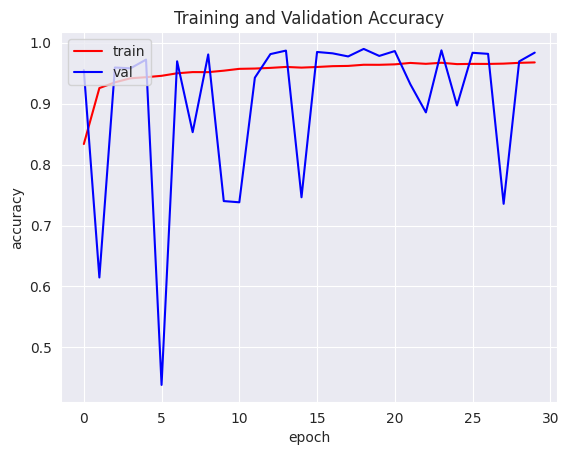

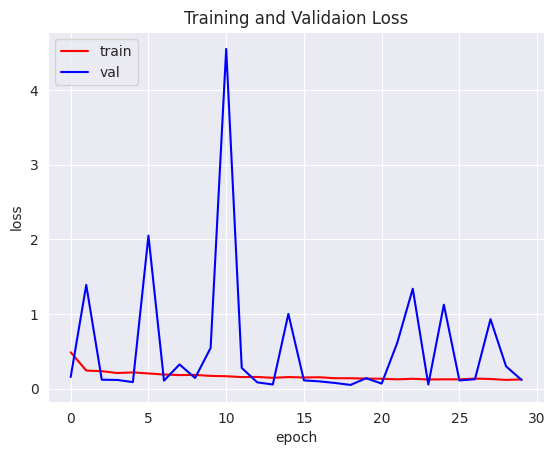

In [47]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [48]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Ambil prediksi dari model
y_pred = model_1.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)  # Mengambil kelas yang diprediksi

# Ambil label sebenarnya
y_true = test_generator.classes

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step
Confusion Matrix:
[[2920    0   12    9   42]
 [   0 2955    0    8    0]
 [   0    0 2988    0    0]
 [   2   77   73 2888    0]
 [  35    0    0    0 2991]]


In [49]:
from sklearn.metrics import classification_report

# Dapatkan laporan klasifikasi
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2983
           1       0.97      1.00      0.99      2963
           2       0.97      1.00      0.99      2988
           3       0.99      0.95      0.97      3040
           4       0.99      0.99      0.99      3026

    accuracy                           0.98     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.98      0.98      0.98     15000





              precision    recall  f1-score   support

     Arborio     0.9875    0.9789    0.9832      2983
     Basmati     0.9746    0.9973    0.9858      2963
      Ipsala     0.9723    1.0000    0.9860      2988
     Jasmine     0.9941    0.9500    0.9716      3040
   Karacadag     0.9862    0.9884    0.9873      3026

    accuracy                         0.9828     15000
   macro avg     0.9829    0.9829    0.9828     15000
weighted avg     0.9830    0.9828    0.9827     15000



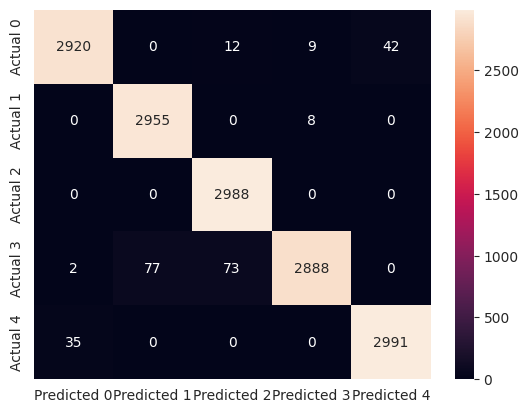

In [79]:
test_generator.reset()

preds_1 = model_1.predict(test_generator,verbose=0)
# Convert predictions to class labels
y_pred = np.argmax(preds_1, axis=1)

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, y_pred, labels=np.unique(test_generator.classes)),
                  index=["Actual " + str(c) for c in np.unique(test_generator.classes)],
                  columns=["Predicted " + str(c) for c in np.unique(test_generator.classes)])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
# Get unique class indices
unique_classes = np.unique(test_generator.classes)

# Assuming 'classes' is a list of class names corresponding to the indices
target_names = [classes[i] for i in unique_classes] # Use original 'classes' list to get names

print(classification_report(y_true=test_generator.classes, y_pred=y_pred, target_names=target_names, digits=4))

## Konversi Model

In [72]:
model_1.save('rice_model.keras')

In [75]:
import os

# Create the directory if it doesn't exist
os.makedirs('saved_model', exist_ok=True)

# Now you can save the model
model_1.save('saved_model/rice_model.keras')

In [76]:
import tensorflow as tf

# Save the model in the SavedModel format
tf.saved_model.save(model_1, 'saved_model')

In [51]:
import tensorflow as tf

# Konversi model Keras ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tflite_model = converter.convert()

# Menyimpan model TensorFlow Lite ke file
with open('rice_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil disimpan dalam format TFLite.")


Saved artifact at '/tmp/tmpkb0ht5ir'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132113019458320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132113019457168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132113019469072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132113019455632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132113019469648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132113019460048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132113019467920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132112867444112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132112867444496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132112867445840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13211286744372

In [53]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [54]:
import tensorflowjs as tfjs

# Konversi model ke TensorFlow.js format
tfjs.converters.save_keras_model(model_1, 'model_tfjs/')

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

In [62]:
print("Expected input shape:", input_details[0]['shape'])

Expected input shape: [  1 150 150   1]


In [64]:
import os

folder = "rice_dataset/dataset/Basmati"
print("Contoh file di dalam folder Basmati:")
print(os.listdir(folder)[:10])


Contoh file di dalam folder Basmati:
['basmati (9960).jpg', 'basmati (11252).jpg', 'basmati (1552).jpg', 'basmati (12975).jpg', 'basmati (12223).jpg', 'basmati (829).jpg', 'basmati (5478).jpg', 'basmati (6657).jpg', 'basmati (3996).jpg', 'basmati (9643).jpg']


In [66]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load model .tflite
interpreter = tf.lite.Interpreter(model_path="rice_model.tflite")
interpreter.allocate_tensors()

# Get model input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Fungsi untuk melakukan preprocessing pada gambar
def preprocess_image(img_path):
       img = image.load_img(img_path, target_size=(150, 150), color_mode='grayscale')
       img_array = image.img_to_array(img)
       img_array = np.expand_dims(img_array, axis=0)
       img_array = img_array / 255.0  # Normalisasi
       return img_array

# Gambar contoh yang ingin diuji
img_path = "rice_dataset/dataset/Basmati/basmati (9960).jpg"
img_array = preprocess_image(img_path)

# Melakukan inferensi
interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()

# Ambil hasil inferensi
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Predicted class probabilities:", output_data)

# Ambil kelas yang diprediksi
predicted_class = np.argmax(output_data)
print("Predicted class:", predicted_class)


Predicted class probabilities: [[0. 1. 0. 0. 0.]]
Predicted class: 1


Interpretasi:
Model dengan yakin (probabilitas 100%) mengenali gambar tersebut sebagai beras jenis Basmati.
Jika gambar uji memang benar dari folder Basmati, maka:

**Model sukses melakukan inferensi dengan akurasi tinggi terhadap data nyata.**

In [67]:
import os

folder = "rice_dataset/dataset/Karacadag"
print("Contoh file di dalam folder Karacadag:")
print(os.listdir(folder)[:10])


Contoh file di dalam folder Karacadag:
['Karacadag (14411).jpg', 'Karacadag (1457).jpg', 'Karacadag (2149).jpg', 'Karacadag (4086).jpg', 'Karacadag (5696).jpg', 'Karacadag (12270).jpg', 'Karacadag (553).jpg', 'Karacadag (11621).jpg', 'Karacadag (12608).jpg', 'Karacadag (14010).jpg']


In [68]:
# Load model SavedModel
saved_model_dir = "rice_model.h5"
model = tf.keras.models.load_model(saved_model_dir)

# Fungsi untuk melakukan preprocessing pada gambar
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150), color_mode='grayscale')  # Sesuaikan dengan ukuran input model
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0  # Normalisasi jika perlu

# Gambar contoh yang ingin diuji
img_path = "rice_dataset/dataset/Karacadag/Karacadag (5969).jpg"
img_array = preprocess_image(img_path)

# Melakukan inferensi
predictions = model.predict(img_array)

# Ambil kelas yang diprediksi
predicted_class = np.argmax(predictions)
print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
Predicted class: 4


Prediksi kelas 4 berarti model memprediksi gambar tersebut termasuk dalam kelas ke-5 dari daftar kelas yang telah dilatih.

Dengan asumsi bahwa ada 5 kelas , kelas ke-5  adalah "Karacadag". Artinya, gambar yang diuji diduga merupakan jenis Karacadag berdasarkan model yang telah dilatih.